In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

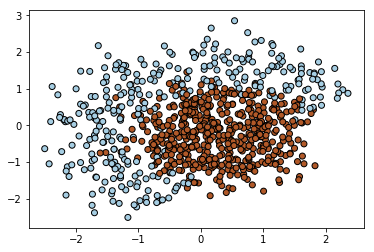

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    
    X_place = tf.placeholder(tf.float64, shape=[None, 2], name='X')
    w_place = tf.placeholder(tf.float64, shape=[6], name='Y')
    
    preds = classify(X_place, w_place)
    
    with tf.Session() as sess:
        Z = sess.run(preds, feed_dict={X_place:np.c_[xx.ravel(), yy.ravel()], w_place:w})

    Z = Z.reshape(xx.shape)
    
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    rows = tf.shape(X)[0]
    ones = tf.ones(shape=(rows, 1), dtype=tf.float64)
    X_ = tf.concat([X, X ** 2, X0 * X1, ones], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples, 2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_ = expand(X)
    w_ = tf.reshape(w, shape=[6, 1])
    rows = tf.shape(X)[0]
    ones = tf.ones(shape=[rows, 1], dtype=tf.float64)
    mulp = tf.matmul(X_, w_)
    Y_pred = tf.where(tf.greater(mulp, 0.0), ones, -ones)
    return Y_pred


The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_ = expand(X)
    w_ = tf.reshape(w, shape=[6, 1])
    rows = tf.shape(X)[0]

    zeros = tf.zeros(shape=(rows, 1), dtype=tf.float64)
    ones = tf.ones(shape=(rows, 1), dtype=tf.float64)
    vec = ones - tf.multiply(y, tf.matmul(X_, w_))
    maxes = tf.reduce_max(tf.concat([zeros, vec], axis=1), axis=1)
    L = tf.reduce_mean(maxes)
    return L
 

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    rows = tf.shape(X)[0]
    zeros = tf.zeros(shape=[rows, 6], dtype=tf.float64)
    ones = tf.ones(shape=[rows, 6], dtype=tf.float64)

    mult = tf.multiply(y, X_)   
    
#     cond = ones - mult
    cond = ones - tf.multiply(w, mult)
    G = tf.reduce_mean(tf.where(tf.less(cond, zeros), zeros, -mult), axis=0)

    return G

In [6]:
def update_weights(w, l, grad):
    return tf.assign(w, w - l * grad)

In [7]:
X_place = tf.placeholder(tf.float64, shape=(None, 2), name='X')
Y_place = tf.placeholder(tf.float64, shape=(None), name='Y')

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

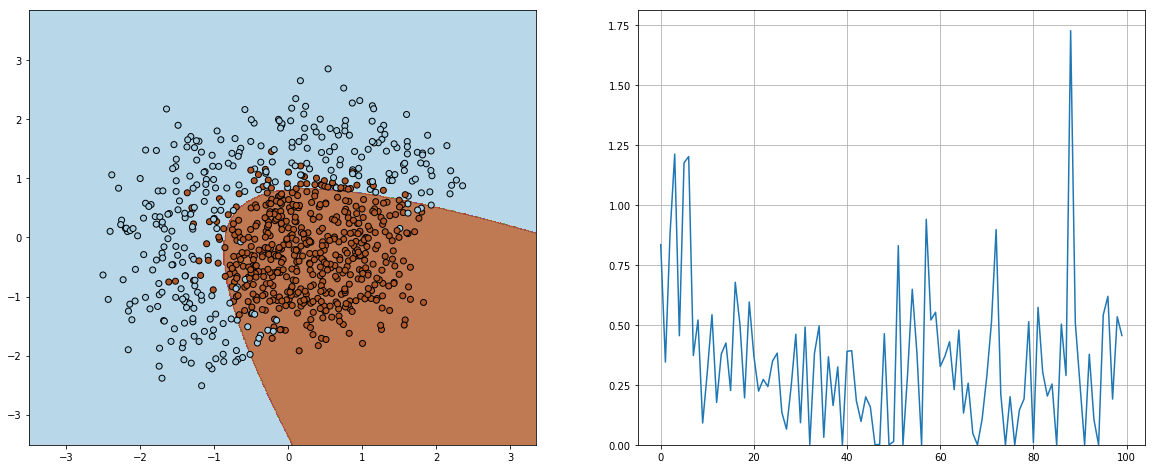

In [8]:
alpha = 0.1 # learning rate

w = np.array([1,0,0,0,0,0], dtype=np.float64)
W = tf.Variable(w, dtype=tf.float64, name='W')

L = compute_loss(X_place, Y_place, W)
grad = compute_grad(X_place, Y_place, W)

n_iter = 50*2
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

W_upd = update_weights(W, alpha, grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        g = sess.run(grad, feed_dict={X_place:X_batch, Y_place:Y_batch})

        loss[i], w, g = sess.run([L, W_upd, grad], feed_dict={X_place:X_batch, Y_place:Y_batch})
#         print(g)
        visualize(X[ind,:], y[ind], w, loss[i], n_iter)        

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

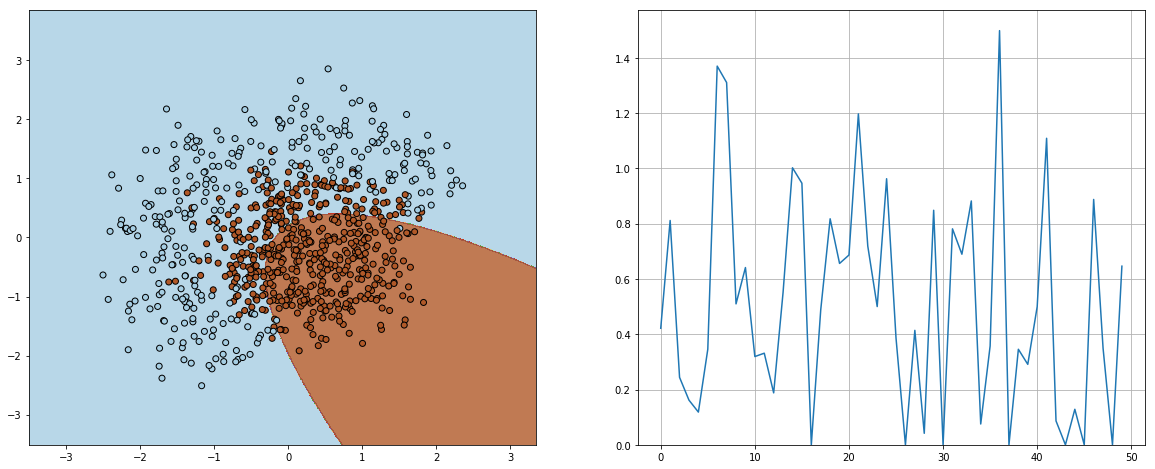

In [9]:
def update_weights_with_mom(w, vel):
    return tf.assign(w, w + vel)
    
alpha = 0.05 # learning rate
mu    = 0.5 # momentum

w = np.array([1,0,0,0,0,0], dtype=np.float64)
W_mom = tf.Variable(w, dtype=tf.float64, name='W')

vel = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='vel')

L_mom = compute_loss(X_place, Y_place, W_mom)
grad_mom = compute_grad(X_place, Y_place, W_mom)

vel_upd = tf.assign(vel, mu * vel - alpha * grad_mom)
W_upd_mom = update_weights_with_mom(W_mom, vel_upd)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i], w, vel_ = sess.run([L_mom, W_upd_mom, vel_upd], feed_dict={X_place:X_batch, Y_place:Y_batch})
        visualize(X[ind,:], y[ind], w, loss[i], n_iter)       

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

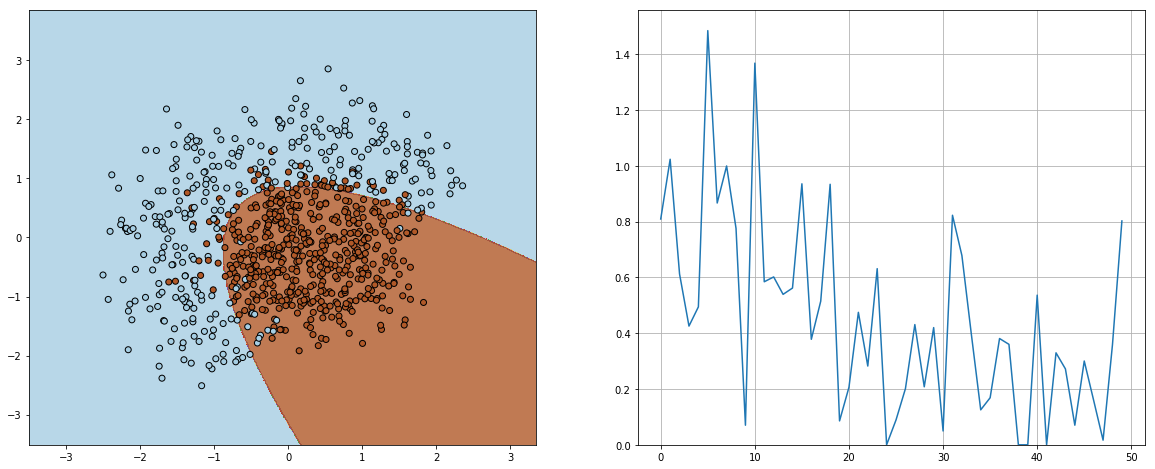

In [23]:
def update_weights_nesterov(w, momentum):
    w_upd = tf.assign(w, w + momentum)
    return w_upd

alpha = 0.05 # learning rate
mu    = 0.3 # momentum

mom = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='momentum')
w = np.array([1,0,0,0,0,0], dtype=np.float32)
W_nesterov = tf.Variable(w, dtype=tf.float64, name='W')

L_nest = compute_loss(X_place, Y_place, W_nesterov)
grad_nest = compute_grad(X_place, Y_place, W_nesterov)

W_upd_with_nesterov = update_weights_nesterov(W_nesterov, mom)
# W_upd_with_grad = update_weights(W_nesterov, alpha, grad_nest)
gradient = - alpha * grad_nest
W_upd_with_grad = tf.assign(W_nesterov, W_nesterov + gradient)
mom_upd = tf.assign(mom, mu * mom + gradient)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        w_upd = sess.run(W_upd_with_nesterov)
        loss[i], w, mom_upd_ = sess.run([L_nest, W_upd_with_grad, mom_upd], feed_dict={X_place:X_batch, Y_place:Y_batch})
        visualize(X[ind,:], y[ind], w, loss[i], n_iter) 

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

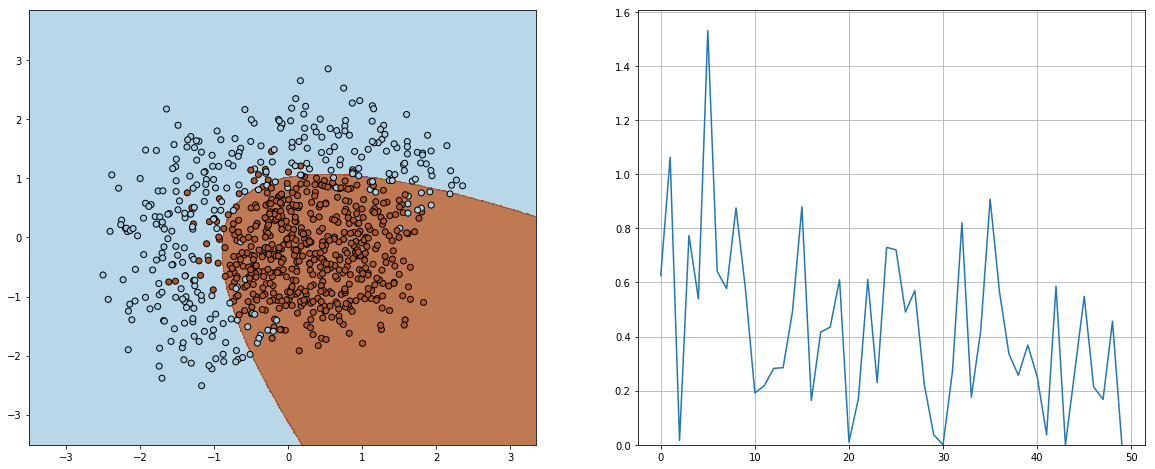

In [11]:
def update_weights_AdaGrad(w, c_w, alpha, eps, grad):
    c_w_upd = tf.assign(c_w, c_w + tf.square(grad))
    w_upd = tf.assign(w, w - alpha / (tf.sqrt(c_w_upd) + eps) * grad)
    return w_upd

alpha = 0.1 # learning rate
gamma = 0.7 # momentum
eps = 1e-8  # A small constant for numerical stability

c_w = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='momentum')
w = np.array([1,0,0,0,0,1], dtype=np.float32)
W_ada = tf.Variable(w, dtype=tf.float64, name='W')

L_ada = compute_loss(X_place, Y_place, W_ada)
grad_ada = compute_grad(X_place, Y_place, W_ada)

W_upd_AdaGrad = update_weights_AdaGrad(W_ada, c_w, alpha, eps, grad_ada)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i], w = sess.run([L_ada, W_upd_AdaGrad], feed_dict={X_place:X_batch, Y_place:Y_batch})
        visualize(X[ind,:], y[ind], w, loss[i], n_iter) 

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

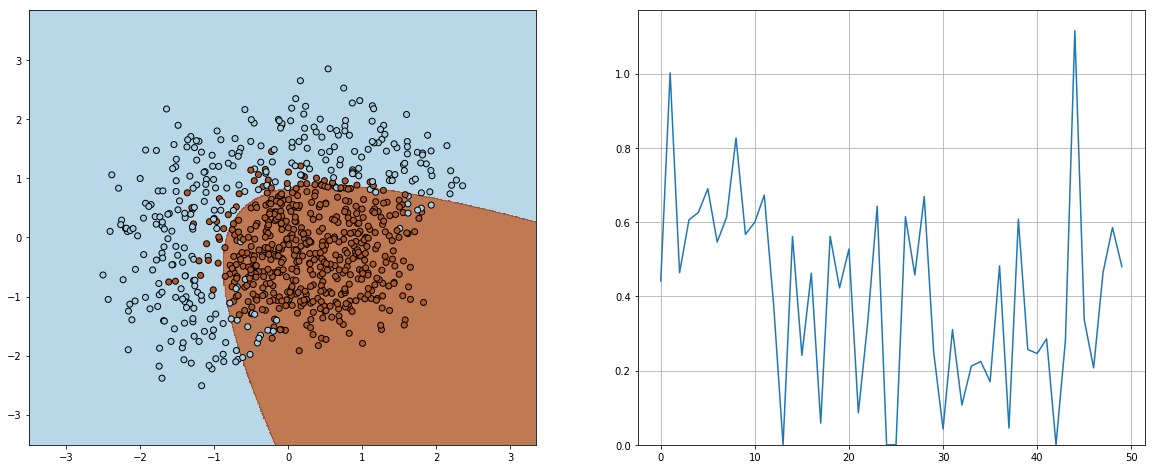

In [14]:
def update_weights_AdaDelta(w, c_w, alpha, beta, eps, grad):
    c_w_upd = tf.assign(c_w, c_w * beta + (1 - beta) * tf.square(grad))
    w_upd = tf.assign(w, w - alpha / (tf.sqrt(c_w_upd) + eps) * grad)
    return w_upd

alpha = 0.1 # learning rate
beta = 0.5
mu    = 0.3 # momentum
eps = 1e-8  # A small constant for numerical stability

w = np.array([1,0,0,0,0,0], dtype=np.float32)
W_delta = tf.Variable(w, dtype=tf.float64, name='W')
c_w_delta = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='momentum')

L_delta = compute_loss(X_place, Y_place, W_delta)
grad_delta = compute_grad(X_place, Y_place, W_delta)

W_upd_AdaDelta = update_weights_AdaDelta(W_delta, c_w_delta, alpha, beta, eps, grad_delta)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i], w = sess.run([L_delta, W_upd_AdaDelta], feed_dict={X_place:X_batch, Y_place:Y_batch})
        visualize(X[ind,:], y[ind], w, loss[i], n_iter)

        
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

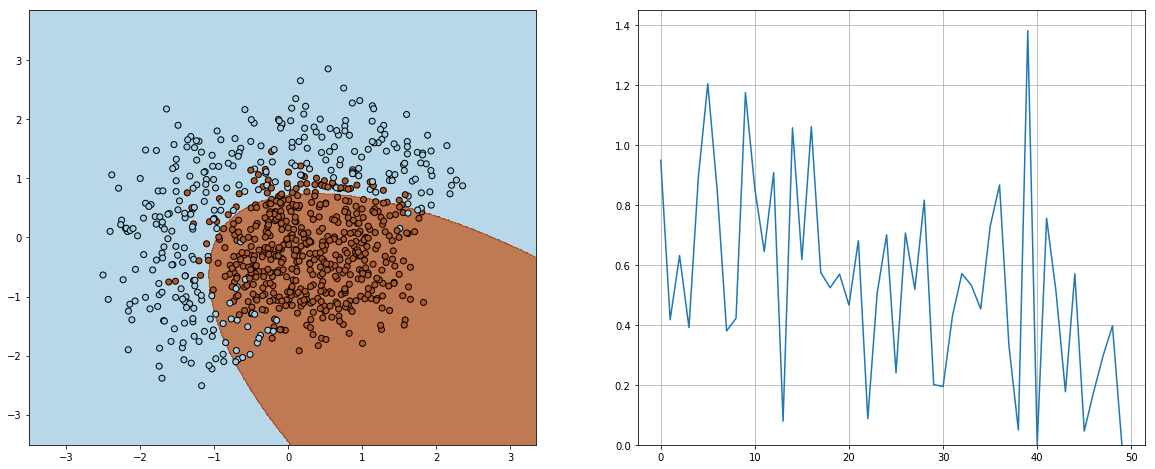

In [17]:
def update_weights_Adam(w, c_w, v_w, alpha, beta, mu, eps, grad):
    c_w_upd = tf.assign(c_w, c_w * beta + (1 - beta) * tf.square(grad))
    v_w_upd = tf.assign(v_w, v_w * mu + (1 - mu) * grad)
    w_upd = tf.assign(w, w - alpha / (tf.sqrt(c_w_upd) + eps) * v_w_upd)
    return w_upd


alpha = 0.05 # learning rate
beta = 0.3  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.3  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

w = np.array([1,0,0,0,0,0], dtype=np.float32)
W_adam = tf.Variable(w, dtype=tf.float64, name='W')
c_w_adam = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='momentum')
v_w_adam = tf.Variable([0,0,0,0,0,0], dtype=tf.float64, name='momentum')

L_adam = compute_loss(X_place, Y_place, W_adam)
grad_adam = compute_grad(X_place, Y_place, W_adam)

W_upd_Adam = update_weights_Adam(W_adam, c_w_adam, v_w_adam, alpha, beta, mu, eps, grad_adam)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind,:]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i], w = sess.run([L_adam, W_upd_Adam], feed_dict={X_place:X_batch, Y_place:Y_batch})
        visualize(X[ind,:], y[ind], w, loss[i], n_iter)

        
visualize(X, y, w, loss, n_iter)
plt.clf()